# Guiding questions

What detailed fields have international students been shifting away from and towards?

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
df = pd.read_csv('../data/GSS_Columbia_Broad.csv', header=4, index_col=False, thousands=',')
df.columns = [
    'Year', 'Institution Name', 'Broad Fields', 'Citizenship', 'Count'
]
df = df.drop('Institution Name', 1) # We assume all data describes Columbia
df = df[1:-3] # Drop first row (total) annd last 3 rows (footnotes)

# Re-structure dataframe into a tree
d = defaultdict(lambda: defaultdict(dict))
for _, row in df.iterrows():
    year = int(row['Year'])
    field = row['Broad Fields']
    citizenship = row['Citizenship']
    d[year][field][citizenship] = row['Count']

ufields = df['Broad Fields'].unique()[1:]

In [3]:
# fields with missing data
badFields = ['Clinical medicine','Neurobiology and neuroscience','Psychology','Other health']
ufields = [f for f in ufields if f not in badFields]

In [4]:
DOM_COL_NAME = 'U.S. citizens and permanent residents (non-U.S. citizens holding green cards)'
INT_COL_NAME = 'Foreign nationals'

DOM_LABEL = 'U.S. citizens & permanent residents'
INT_LABEL = INT_COL_NAME

In [5]:
years = np.arange(1994, 2017)

In [6]:
def sumLists(a, b):
    return [(a[i] or 0) + (b[i] or 0) for i in range(len(a))]

yearTotals = [0 for _ in range(len(years))]
fieldCounts = {}
for f in ufields:
    fieldCounts[f] = [d[year][f].get(INT_COL_NAME, None) for year in years]
    yearTotals = sumLists(yearTotals, fieldCounts[f])

# How can we best visualize the changing distribution?

In [7]:
from scipy.interpolate import interp1d
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [8]:
viridisBig = cm.get_cmap('viridis', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.1, 0.95, 256)))

## Stacked area chart

Engineering first: 26%, last: 50%
Mathematics and statistics first: 7%, last: 19%
Computer sciences first: 7%, last: 10%
Social sciences first: 23%, last: 10%
Biological sciences first: 19%, last: 6%
Earth, atmospheric, and ocean sciences first: 5%, last: 3%
Physical sciences first: 12%, last: 2%


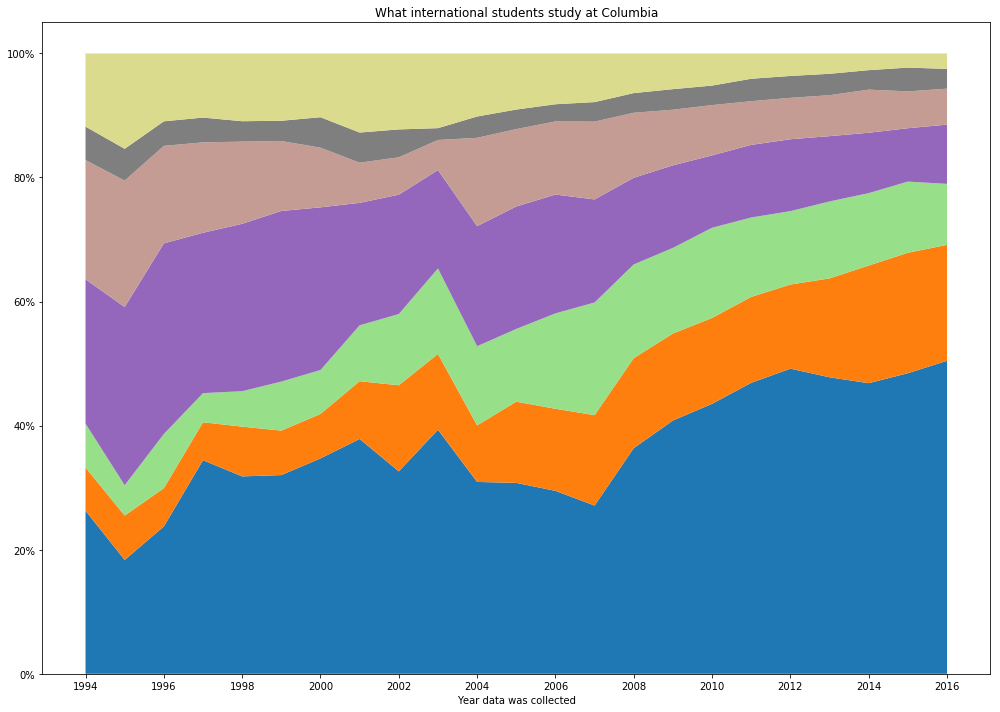

In [19]:
sortedFields = sorted(ufields, key=lambda x: fieldCounts[x][-1] or 0, reverse=True)

plt.figure(figsize=(14, 10))

stacks = []
colors = []
for i, f in enumerate(sortedFields):
    counts = []
    for y in range(len(years)):
        c = fieldCounts[f][y]
        counts.append(c / yearTotals[y])
    stacks.append(counts)
    print(f, 'first: {:,.0%}, last: {:,.0%}'.format(counts[0], counts[-1]))
    colors.append(cm.tab20(i / len(sortedFields)))

ax = plt.subplot(111)
plt.stackplot(years, stacks, labels=sortedFields, colors=colors, linewidth=0)

# Make y values percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# Make legend on right side of graph
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Year data was collected')
plt.xticks(np.arange(min(years), max(years) + 1, 2))
plt.title('What international students study at Columbia')

plt.tight_layout()
plt.savefig('stacked_broads.pdf', transparent=True)

## Percent Changes

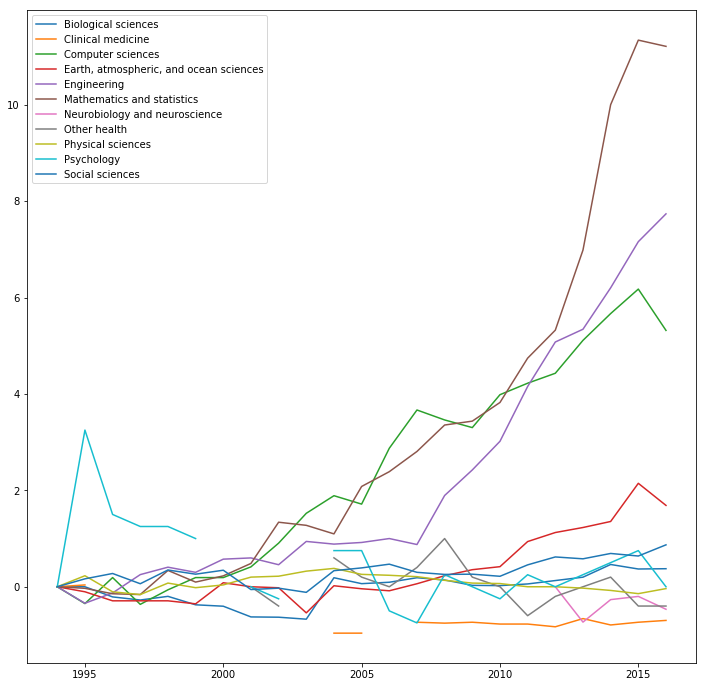

In [10]:
def percentChanges(counts):
    startIdx = next((i for i in range(len(counts)) if counts[i] is not None), None)
    if startIdx is None:
        return counts
    
    start = counts[startIdx]
    return [None]*startIdx + [None if counts[i] is None else (counts[i]-start)/start for i in range(startIdx, len(counts))]

plt.figure(figsize=(12, 12))
for f in ufields:
    plt.plot(years, percentChanges(fieldCounts[f]), label=f)
plt.legend()

## Animated bumping bar chart

In [90]:
def barChart(year):
    yPos = np.arange(len(ufields))
    fields, counts = zip(*sorted([(field, fieldCounts[field][year - min(years)]) for field in ufields], key=lambda x: (x[1] or 0)))

    plt.barh(yPos, [c or 0 for c in counts], align='center', alpha=0.5)
    plt.yticks(yPos, fields)
    plt.title(year)
    plt.tight_layout()
    plt.savefig(f'./broad-distr-gif/{year}.png')
    plt.clf()

plt.figure(figsize=(11, 8))
! mkdir broad-distr-gif
for y in years:
    barChart(y)
! convert -delay 80 broad-distr-gif/*.png animated-broad-distribution.gif
! rm -r broad-distr-gif

<Figure size 792x576 with 0 Axes>

![animated](animated-broad-distribution.gif)

## Ridgeplot-like subplots

In [17]:
def plotProportion(ax, field, xaxis=False, color='black', label=True):
    where = []
    counts = []
    for y in range(len(years)):
        c = fieldCounts[field][y]
        counts.append((c or -1) / yearTotals[y])
        where.append(c is not None)

    spacedYears = np.linspace(years[0], years[-1], 460)
    f = interp1d(years, counts, kind='quadratic')
    smoothCounts=f(spacedYears)
    
    spacedWhere = sum(([w] * 20 for w in where), [])

    ax.fill_between(spacedYears, 0, smoothCounts, where=spacedWhere, color=color, linewidth=0)
    
    smoothCounts = [smoothCounts[i] if spacedWhere[i] else None for i in range(len(smoothCounts))]
    ax.plot(spacedYears, smoothCounts, color='black')
    
    if label:
        ax.set_title(field, x=.97, y=0.25, loc='left')

    ax.xaxis.set_ticks(np.arange(years[0], years[-1] + 1, 2))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.yaxis.set_visible(False)

    ax.set_ylim(bottom=0, top=0.4)
    
    if xaxis:
        ax.xaxis.set_visible(False)

In [18]:
def plotDistributions(export=False):
    fig, axarr = plt.subplots(len(ufields), 1, sharex=True, sharey=True, figsize=(18, 12))

    for i in range(len(ufields)):
        plotProportion(
            axarr[i],
            ufields[i],
            xaxis=(i != len(ufields) - 1),
            color=newcmp(1 - i / len(ufields)),
            label=(not export)
        )

    if export:
        fig.savefig('student_distribution_broad.pdf', transparent=True)
    else:
        fig.text(
            0.5, 
            0.96,
            'Columbia international graduate student distribution between selected fields',
            ha='center', 
            fontsize=14
        )
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

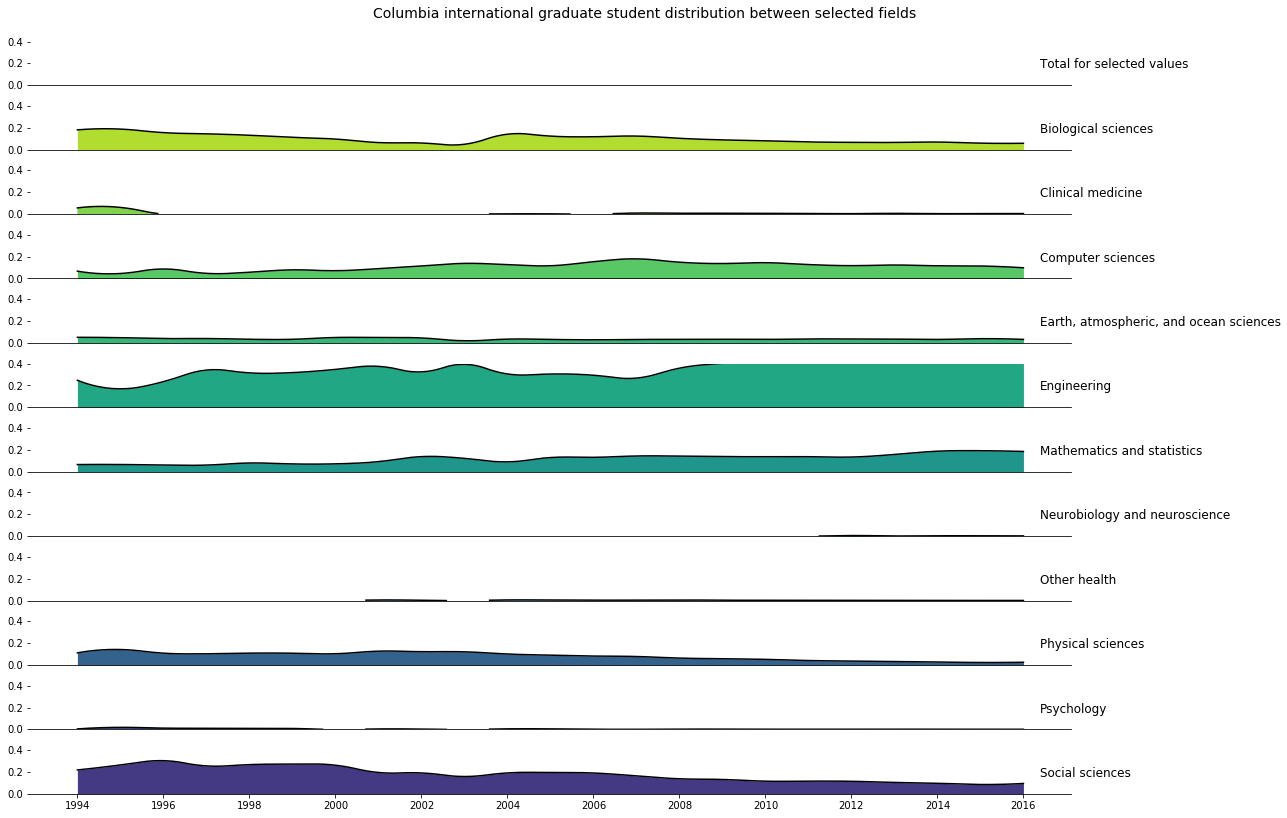

In [19]:
plotDistributions()